In [3]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

### Load in scores and outputs from BoN (up to 32)

In [ ]:
# Read the completions data
completions_path = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32_numina_sixth_chunk/best_of_n_completions.jsonl/best_of_n_completions.jsonl"
with open(completions_path, "r") as f:
    completions_data = [json.loads(line) for line in f]

df_completions = pd.DataFrame(completions_data)
df_completions["problem"], df_completions["completion_tokens"]

,source,problem,solution,messages,answer,completions,scores,pred,completion_tokens,agg_scores,...,indicator_maj@16,indicator_naive@16,correctness@16,pred_weighted@32,pred_maj@32,pred_naive@32,indicator_weighted@32,indicator_maj@32,indicator_naive@32,correctness@32
0,orca_math,Kendra wants enough shirts that she only has t...,Let's calculate the number of shirts Kendra ne...,[{'content': 'Kendra wants enough shirts that ...,22,"[To solve this problem, let's break it down st...","[[0.984375, 0.0128173828, 0.12890625, 0.186523...","To solve this problem, we need to calculate th...","[203, 278, 376, 329, 338, 335, 15, 414, 349, 3...","[0.1865234375, 0.9609375, 1.0, 1.0, 1.0, 0.202...",...,1,0,"[False, False, False, False, True, False, Fals...",\boxed{20},\boxed{20},\boxed{20},0,0,0,"[False, False, False, False, True, False, Fals..."
1,math,"Solve for $n$, if $9^n\cdot9^n\cdot9^n\cdot9^n...",To solve for $n$ in the equation $9^n\cdot9^n\...,"[{'content': 'Solve for $n$, if $9^n\cdot9^n\c...",2,[## Step 1: Rewrite the equation by combining ...,"[[0.98046875, 0.99609375, 0.0205078125, 0.4218...",## Step 1: Rewrite the equation by combining l...,"[418, 185, 448, 345, 203, 291, 422, 240, 333, ...","[1.0, 1.0, 0.9921875, 1.0, 0.54296875, 1.0, 0....",...,1,0,"[False, True, True, True, False, False, False,...",\boxed{2},\boxed{2},\boxed{1},1,1,0,"[False, True, True, True, False, False, False,..."
2,cn_k12,Find the value; \nA line passing through the ...,Given the ellipse: $\dfrac{x^2}{a^2} + \dfrac{...,[{'content': 'Find the value; A line passing...,2,"[To solve the problem, we need to find the val...","[[0.52734375, 0.98046875, 0.73828125, 0.050292...",Given the ellipse \(E: \frac{x^2}{25} + \frac{...,"[1412, 869, 1429, 1090, 399, 1261, 1310, 779, ...","[0.2177734375, 0.9765625, 0.9375, 1.0, 1.0, 0....",...,1,1,"[True, True, True, True, True, True, True, Tru...",\boxed{2},\boxed{2},\boxed{2},1,1,1,"[True, True, True, True, True, True, True, Tru..."
3,cn_k12,"In tetrahedron $O\_ (ABC)$, point $M$ is on $O...",The problem primarily examines the application...,"[{'content': 'In tetrahedron $O\_ (ABC)$, poin...",x = 1,[To solve for the value of \( x \) that makes ...,"[[0.95703125, 0.7578125, 1.0, 1.0, 0.98828125,...","To solve this problem, we need to find the val...","[1309, 1184, 960, 931, 1102, 1017, 1094, 964, ...","[0.98828125, 0.77734375, 0.98828125, 0.2832031...",...,0,0,"[False, False, False, False, True, True, True,...",\boxed{x=1},\boxed{x=1},\boxed{1},1,1,1,"[False, False, False, False, True, True, True,..."
4,synthetic_math,"Let $WXYZ$ be a square pyramid with $W$, $X$, ...",Visualize a square pyramid with a square base ...,[{'content': 'Let $WXYZ$ be a square pyramid w...,\frac{1}{3},[To solve for \(\cos \angle VPZ\) in the given...,"[[0.7890625, 0.98046875, 0.0732421875, 0.82031...","To solve the problem, we need to calculate the...","[1061, 702, 1205, 592, 691, 1140, 815, 805, 28...","[0.62890625, 0.94140625, 0.8046875, 0.62109375...",...,0,0,"[False, False, False, False, False, False, Fal...",\boxed{0},\boxed{0},\boxed{0},0,0,0,"[False, False, False, False, False, False, Fal..."


In [3]:
#### Loading Soft Labels
import json

# Paths to the JSONL files
input_files = {
    "softlabels_2": "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32_numina/softlabels_2.jsonl",
    "softlabels_4": "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32_numina/softlabels_4.jsonl",
    "softlabels_8": "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32_numina/softlabels_8.jsonl",
    "softlabels_16": "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32_numina/softlabels_16.jsonl",
    "softlabels_32": "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32_numina/softlabels_32.jsonl",
}

# Load each JSONL file into a DataFrame
dataframes = {}
for label, path in input_files.items():
    data = []
    with open(path, "r") as infile:
        for line in infile:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    dataframes[label] = df

# Merge the DataFrames on the "problem" column
merged_df = dataframes["softlabels_2"]
for label in ["softlabels_4", "softlabels_8", "softlabels_16", "softlabels_32"]:
    merged_df = merged_df.merge(dataframes[label], on="problem", suffixes=("", f"_{label}"))

merged_df.head()

# Rename columns to simplify names (e.g., sl_weighted_2_softlabels_4 -> sl_weighted_4)
rename_columns = {
    f"sl_weighted_2_softlabels_4": "sl_weighted_4",
    f"sl_naive_2_softlabels_4": "sl_naive_4",
    f"sl_maj_2_softlabels_4": "sl_maj_4",
    f"sl_weighted_2_softlabels_8": "sl_weighted_8",
    f"sl_naive_2_softlabels_8": "sl_naive_8",
    f"sl_maj_2_softlabels_8": "sl_maj_8",
    f"sl_weighted_2_softlabels_16": "sl_weighted_16",
    f"sl_naive_2_softlabels_16": "sl_naive_16",
    f"sl_maj_2_softlabels_16": "sl_maj_16",
    f"sl_weighted_2_softlabels_32": "sl_weighted_32",
    f"sl_naive_2_softlabels_32": "sl_naive_32",
    f"sl_maj_2_softlabels_32": "sl_maj_32",
}

# Apply renaming
merged_df.rename(columns=rename_columns, inplace=True)

merged_df.tail()
## Save the merged DataFrame to a CSV file
# output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/numina_merged_softlabels.csv"
# merged_df.to_csv(output_file, index=False)
# print(f"Merged DataFrame saved to {output_file}")

,problem,sl_weighted_2,sl_naive_2,sl_maj_2,sl_weighted_4,sl_naive_4,sl_maj_4,sl_weighted_8,sl_naive_8,sl_maj_8,sl_weighted_16,sl_naive_16,sl_maj_16,sl_weighted_32,sl_naive_32,sl_maj_32
4993,"Numbers $1, 2, \ldots, 8$ are written in some ...",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4994,Mrs. Fredrickson has 80 chickens where 1/4 ar...,0.133333,0.133333,0.1,0.2,0.2,0.066667,0.2,0.2,0.033333,0.566667,0.533333,0.0,0.7,0.7,0.0
4995,Measure the diagonal of a brick that has the s...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4996,Given the quadratic function \( y = x^2 + 2mx ...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4997,Find the volume of the region in space defined...,0.000000,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [4]:
# read in merged_df (i.e., the merged soft labels).
merged_df = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32_numina/numina_merged_softlabels.csv")
# merged_df.head()

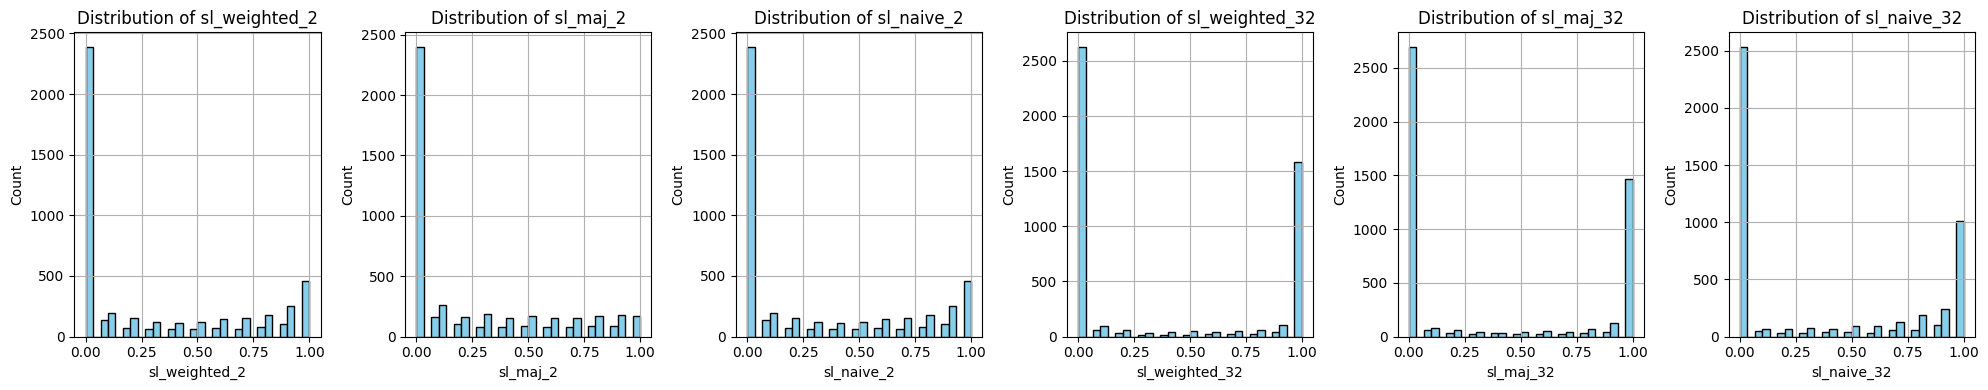

In [5]:
import matplotlib.pyplot as plt

cols_to_plot = ["sl_weighted_2", "sl_maj_2", "sl_naive_2", "sl_weighted_32", "sl_maj_32", "sl_naive_32"]
fig, axes = plt.subplots(1, 6, figsize=(20, 4))

for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    merged_df[col].hist(ax=ax, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [29]:
# Load and process the .jsonl file
def load_jsonl_extract_accuracy(jsonl_path):
    data = []

    with open(jsonl_path, "r") as f:
        for line in f:
            entry = json.loads(line)
            question = entry["problem"]
            score_list = entry["agg_scores"] 
            completion_tokens = entry["completion_tokens"]
            indicator_weighted_1 = entry["indicator_weighted@1"]
            indicator_naive_1 = entry["indicator_naive@1"]
            indicator_maj_1 = entry["indicator_maj@1"]
            indicator_weighted_2 = entry["indicator_weighted@2"]
            indicator_naive_2 = entry["indicator_naive@2"]
            indicator_maj_2 = entry["indicator_maj@2"]
            indicator_weighted_4 = entry["indicator_weighted@4"]
            indicator_naive_4 = entry["indicator_naive@4"]
            indicator_maj_4 = entry["indicator_maj@4"]
            indicator_weighted_8 = entry["indicator_weighted@8"]
            indicator_naive_8 = entry["indicator_naive@8"]
            indicator_maj_8 = entry["indicator_maj@8"]
            indicator_weighted_16 = entry["indicator_weighted@16"]
            indicator_naive_16 = entry["indicator_naive@16"]
            indicator_maj_16 = entry["indicator_maj@16"]
            indicator_weighted_32 = entry["indicator_weighted@32"]
            indicator_naive_32 = entry["indicator_naive@32"]
            indicator_maj_32 = entry["indicator_maj@32"]
            correctness_1 = entry["correctness@1"]
            correctness_2 = entry["correctness@2"]
            correctness_4 = entry["correctness@4"]
            correctness_8 = entry["correctness@8"]
            correctness_16 = entry["correctness@16"]
            correctness_32 = entry["correctness@32"]
            data.append({
                "question": question,
                "score": score_list,
                "score_list": score_list,
                "completion_tokens": completion_tokens,
                "indicator_weighted_1": indicator_weighted_1,
                "indicator_naive_1": indicator_naive_1,
                "indicator_maj_1": indicator_maj_1,
                "indicator_weighted_2": indicator_weighted_2,
                "indicator_naive_2": indicator_naive_2,
                "indicator_maj_2": indicator_maj_2,
                "indicator_weighted_4": indicator_weighted_4,
                "indicator_naive_4": indicator_naive_4,
                "indicator_maj_4": indicator_maj_4,
                "indicator_weighted_8": indicator_weighted_8,
                "indicator_naive_8": indicator_naive_8,
                "indicator_maj_8": indicator_maj_8,
                "indicator_weighted_16": indicator_weighted_16,
                "indicator_naive_16": indicator_naive_16,
                "indicator_maj_16": indicator_maj_16, # indicator for correctness of maj at 16 generations.
                "indicator_weighted_32": indicator_weighted_32,
                "indicator_naive_32": indicator_naive_32,
                "indicator_maj_32": indicator_maj_32,
                "correctness_1": correctness_1,
                "correctness_2": correctness_2,
                "correctness_4": correctness_4,
                "correctness_8": correctness_8,
                "correctness_16": correctness_16, 
                 "correctness_32": correctness_32, # list of whether each of 32 generations is correct or not.
            })

    return pd.DataFrame(data)
df_bon = load_jsonl_extract_accuracy("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32_numina/best_of_n_completions.jsonl/best_of_n_completions.jsonl")
df_bon.shape
# add column for question index.
df_bon["sb_idx"] = df_bon.index.tolist()
df_bon.columns

Index(['question', 'score', 'score_list', 'completion_tokens',
       'indicator_weighted_1', 'indicator_naive_1', 'indicator_maj_1',
       'indicator_weighted_2', 'indicator_naive_2', 'indicator_maj_2',
       'indicator_weighted_4', 'indicator_naive_4', 'indicator_maj_4',
       'indicator_weighted_8', 'indicator_naive_8', 'indicator_maj_8',
       'indicator_weighted_16', 'indicator_naive_16', 'indicator_maj_16',
       'indicator_weighted_32', 'indicator_naive_32', 'indicator_maj_32',
       'correctness_1', 'correctness_2', 'correctness_4', 'correctness_8',
       'correctness_16', 'correctness_32', 'sb_idx'],
      dtype='object')

In [30]:
# rename problem to question in merged_df.
merged_df.rename(columns={"problem": "question"}, inplace=True)
# merged_df

In [31]:
# join with df_bon keeping all columns from both dataframes
data_w_softlabels = merged_df.merge(df_bon, on="question", how="left")
data_w_softlabels
data_w_softlabels.columns
# create pivot table.

# Columns to melt (soft labels)
sl_cols = [
    "sl_weighted_2", "sl_naive_2", "sl_maj_2",
    "sl_weighted_4", "sl_naive_4", "sl_maj_4",
    "sl_weighted_8", "sl_naive_8", "sl_maj_8",
    "sl_weighted_16", "sl_naive_16", "sl_maj_16",
    "sl_weighted_32", "sl_naive_32", "sl_maj_32",
]

# Melt the dataframe from wide to long
predictor_df = data_w_softlabels.melt(
    id_vars=['question', 'score', 'completion_tokens', 'sb_idx'], # , 'correctness_32'
    value_vars=sl_cols,
    var_name='method_N',
    value_name='sl'
) # indicator: whether the final answer is correct.

# # Extract method and N from 'method_N'
predictor_df[['drop', 'method', 'N']] = predictor_df['method_N'].str.extract(r'(sl)_(\w+?)_(\d+)')
predictor_df.drop(columns=['method_N', 'drop'], inplace=True)

# Convert N to integer
predictor_df['N'] = predictor_df['N'].astype(int)

# Show result
predictor_df.head()

,question,score,completion_tokens,sb_idx,sl,method,N
0,Consider the terms of an arithmetic sequence: ...,"[0.9921875, 0.0092773438, 1.0, 1.0, 1.0, 0.138...","[478, 245, 551, 429, 581, 485, 433, 404, 496, ...",0,0.766667,weighted,2
1,Suppose that $g(x) = 5x - 3$. What is $g^{-1}(...,"[0.1098632812, 1.0, 0.99609375, 0.98828125, 0....","[372, 320, 328, 347, 238, 347, 409, 292, 321, ...",1,0.533333,weighted,2
2,A farmer has a rectangular field with dimensio...,"[0.87890625, 0.0008544922, 0.0065917969, 0.558...","[532, 533, 709, 819, 743, 413, 1128, 331, 627,...",2,0.000000,weighted,2
3,Given the functions $f(x) = \log_a(1+x)$ and $...,"[0.9140625, 1.0, 0.0247802734, 1.0, 0.00744628...","[895, 922, 438, 957, 394, 822, 899, 939, 947, ...",3,0.000000,weighted,2
4,Find all solutions to the equation $\displayst...,"[1.0, 0.99609375, 0.99609375, 1.0, 1.0, 1.0, 1...","[296, 302, 352, 200, 284, 222, 186, 194, 257, ...",4,0.933333,weighted,2


In [ ]:
### change completion_tokens froms str --> a list of ints.
predictor_df["completion_tokens"] = predictor_df["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Compute length of question (aka, length of the string)
predictor_df["question_length"] = predictor_df["question"].str.len()
# Compute token count from completion_tokens
# predictor_df["token_count"] = predictor_df["completion_tokens"].apply(sum)
# turn completion tokens into a list of ints.
predictor_df["completion_tokens"] = predictor_df["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Obtain Token Count for Best of N.
predictor_df["token_count"] = predictor_df.apply(lambda row: sum(row["completion_tokens"][:row["N"]]), axis=1)
predictor_df = pd.get_dummies(predictor_df, columns=["method"])
predictor_df.shape
# Transform method columns into a single 'method' column.

def decode_method(row):
    if row["method_majority"]:
        return "majority"
    elif row["method_naive"]:
        return "naive"
    elif row["method_weighted"]:
        return "weighted"
    elif row["method_beam_search"]:
        return "beam_search"
    else:
        return "unknown"

# Apply the function row-wise
predictor_df["method"] = predictor_df.apply(decode_method, axis=1)

,question,score,completion_tokens,sb_idx,sl,N,question_length,token_count,method_maj,method_naive,method_weighted,method
0,Consider the terms of an arithmetic sequence: ...,"[0.9921875, 0.0092773438, 1.0, 1.0, 1.0, 0.138...","[478, 245, 551, 429, 581, 485, 433, 404, 496, ...",0,0.766667,2,93,723,False,False,True,weighted
1,Suppose that $g(x) = 5x - 3$. What is $g^{-1}(...,"[0.1098632812, 1.0, 0.99609375, 0.98828125, 0....","[372, 320, 328, 347, 238, 347, 409, 292, 321, ...",1,0.533333,2,59,692,False,False,True,weighted
2,A farmer has a rectangular field with dimensio...,"[0.87890625, 0.0008544922, 0.0065917969, 0.558...","[532, 533, 709, 819, 743, 413, 1128, 331, 627,...",2,0.000000,2,167,1065,False,False,True,weighted
3,Given the functions $f(x) = \log_a(1+x)$ and $...,"[0.9140625, 1.0, 0.0247802734, 1.0, 0.00744628...","[895, 922, 438, 957, 394, 822, 899, 939, 947, ...",3,0.000000,2,253,1817,False,False,True,weighted
4,Find all solutions to the equation $\displayst...,"[1.0, 0.99609375, 0.99609375, 1.0, 1.0, 1.0, 1...","[296, 302, 352, 200, 284, 222, 186, 194, 257, ...",4,0.933333,2,81,598,False,False,True,weighted
...,...,...,...,...,...,...,...,...,...,...,...,...
74995,"Numbers $1, 2, \ldots, 8$ are written in some ...","[0.287109375, 0.99609375, 0.69140625, 0.917968...","[768, 474, 711, 702, 497, 626, 412, 1138, 420,...",4995,0.000000,32,416,23186,True,False,False,majority
74996,Mrs. Fredrickson has 80 chickens where 1/4 ar...,"[0.0126342773, 0.0344238281, 0.0058288574, 0.0...","[240, 240, 203, 260, 282, 143, 277, 246, 226, ...",4996,0.000000,32,188,7884,True,False,False,majority
74997,Measure the diagonal of a brick that has the s...,"[0.99609375, 0.94140625, 0.9296875, 0.85546875...","[350, 200, 275, 330, 433, 333, 443, 482, 340, ...",4997,0.000000,32,262,11901,True,False,False,majority
74998,Given the quadratic function \( y = x^2 + 2mx ...,"[1.0, 0.94140625, 0.91796875, 0.259765625, 0.0...","[1762, 1110, 1470, 828, 810, 797, 1016, 641, 7...",4998,0.000000,32,250,27679,True,False,False,majority


#### Load Beam Soft Labels

In [33]:
import importlib
import extract_sl_maj_N
importlib.reload(extract_sl_maj_N)

beam_2_4_40_softlabels = extract_sl_maj_N.extract_sl_maj_N_from_jsonl('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_numina/beam_search_2_4_40/softlabels_2.jsonl', 2)
beam_4_4_40_softlabels = extract_sl_maj_N.extract_sl_maj_N_from_jsonl('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_numina/beam_search_4_4_40/softlabels_4.jsonl', 4)
beam_8_4_40_softlabels = extract_sl_maj_N.extract_sl_maj_N_from_jsonl('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_numina/beam_search_8_4_40/softlabels_8.jsonl', 8)
beam_16_4_40_softlabels = extract_sl_maj_N.extract_sl_maj_N_from_jsonl('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_numina/beam_search_16_4_40/softlabels_16.jsonl', 16)
beam_32_4_40_softlabels = extract_sl_maj_N.extract_sl_maj_N_from_jsonl('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_search_32_4_40/softlabels_32.jsonl', 32)

In [ ]:
import importlib
import extract_sl_maj_N
importlib.reload(extract_sl_maj_N)

/dccstor/gma2/jhjenny9/search-and-learn/data/sl/sequential/softlabels_2.jsonl

In [34]:
beam_2_4_40_softlabels.head()

,sb_idx,sl,method,N,question
0,0,1.000000,beam_search,2,Consider the terms of an arithmetic sequence: ...
1,1,0.566667,beam_search,2,Suppose that $g(x) = 5x - 3$. What is $g^{-1}(...
2,2,0.000000,beam_search,2,A farmer has a rectangular field with dimensio...
3,3,0.000000,beam_search,2,Given the functions $f(x) = \log_a(1+x)$ and $...
4,4,1.000000,beam_search,2,Find all solutions to the equation $\displayst...


In [35]:
# concatenate beam softlabel files into one file.
import numpy as np

beam_sl_all = pd.concat([beam_2_4_40_softlabels, beam_4_4_40_softlabels, beam_8_4_40_softlabels, beam_16_4_40_softlabels, beam_32_4_40_softlabels], ignore_index=True)
beam_sl_all.head()
# beam_sl_all.shape

,sb_idx,sl,method,N,question
0,0,1.000000,beam_search,2,Consider the terms of an arithmetic sequence: ...
1,1,0.566667,beam_search,2,Suppose that $g(x) = 5x - 3$. What is $g^{-1}(...
2,2,0.000000,beam_search,2,A farmer has a rectangular field with dimensio...
3,3,0.000000,beam_search,2,Given the functions $f(x) = \log_a(1+x)$ and $...
4,4,1.000000,beam_search,2,Find all solutions to the equation $\displayst...


#### Read in Beam-Search Files.

In [36]:
def load_jsonl_extract_for_N(jsonl_path, N):
    data = []

    with open(jsonl_path, "r") as f:
        for line in f:
            entry = json.loads(line)
            question = entry["problem"]
            score_list = entry["agg_scores"] 
            completion_tokens = entry["completion_tokens"]
            indicator_weighted = entry.get(f"indicator_weighted@{N}")
            indicator_naive = entry.get(f"indicator_naive@{N}")
            indicator_maj = entry.get(f"indicator_maj@{N}")
            correctness = entry.get(f"correctness@{N}")

            data.append({
                "question": question,
                "score": score_list,
                "completion_tokens": completion_tokens,
                f"indicator": indicator_maj,
                # f"correctness": correctness,
                "method": "beam_search",
                "N": N,
            })

    return pd.DataFrame(data)

In [37]:
beam_2_4_40 = load_jsonl_extract_for_N('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_numina/beam_search_2_4_40/beam_search_completions.jsonl', 2)
beam_4_4_40 = load_jsonl_extract_for_N('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_numina/beam_search_4_4_40/beam_search_completions.jsonl', 4)
beam_8_4_40 = load_jsonl_extract_for_N('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_numina/beam_search_8_4_40/beam_search_completions.jsonl', 8)
beam_16_4_40 = load_jsonl_extract_for_N('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_numina/beam_search_16_4_40/beam_search_completions.jsonl', 16)
beam_32_4_40 = load_jsonl_extract_for_N('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_search_32_4_40/beam_search_completions.jsonl', 32)

In [38]:
# add question index.
beam_2_4_40["sb_idx"] = beam_2_4_40.index.tolist()
beam_4_4_40["sb_idx"] = beam_4_4_40.index.tolist()
beam_8_4_40["sb_idx"] = beam_8_4_40.index.tolist()
beam_16_4_40["sb_idx"] = beam_16_4_40.index.tolist()
beam_32_4_40["sb_idx"] = beam_32_4_40.index.tolist()

# concatenate all beam search dataframes.
beam_df = pd.concat([beam_2_4_40, beam_4_4_40, beam_8_4_40, beam_16_4_40, beam_32_4_40], ignore_index=True)

In [39]:
# join beam_df with beam_sl_all.
beam_df_with_sl = pd.merge(
    beam_df,
    beam_sl_all,
    on=["question",  "method", "N"],
    how="outer"
)

In [40]:
# drop sb_idx_x and sb_idx_y.
beam_df_with_sl = beam_df_with_sl.drop(columns=["sb_idx_x", "sb_idx_y"])
beam_df_with_sl.head()

,question,score,completion_tokens,indicator,method,N,sl
0,\n(a) To which class (type) of goods (services...,"[0.9765625, 0.97265625]","[503, 838]",0,beam_search,2,0.0
1,\n(a) To which class (type) of goods (services...,"[0.8125, 0.9765625, 0.322265625, 0.9375]","[0, 0, 0, 0]",0,beam_search,4,0.0
2,\n(a) To which class (type) of goods (services...,"[0.94921875, 0.9921875, 0.94921875, 0.9765625,...","[523, 491, 524, 539, 618, 599, 604, 614]",0,beam_search,8,0.0
3,\n(a) To which class (type) of goods (services...,"[0.2216796875, 0.9140625, 0.984375, 0.9609375,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,beam_search,16,0.0
4,\nA $10 \times 10$ table is filled with number...,"[0.9296875, 0.9921875]","[693, 691]",0,beam_search,2,0.0


In [41]:
# Compute length of question (aka, length of the string)
beam_df_with_sl["question_length"] = beam_df_with_sl["question"].str.len()

In [42]:
beam_df_with_sl.head()

,question,score,completion_tokens,indicator,method,N,sl,question_length
0,\n(a) To which class (type) of goods (services...,"[0.9765625, 0.97265625]","[503, 838]",0,beam_search,2,0.0,610
1,\n(a) To which class (type) of goods (services...,"[0.8125, 0.9765625, 0.322265625, 0.9375]","[0, 0, 0, 0]",0,beam_search,4,0.0,610
2,\n(a) To which class (type) of goods (services...,"[0.94921875, 0.9921875, 0.94921875, 0.9765625,...","[523, 491, 524, 539, 618, 599, 604, 614]",0,beam_search,8,0.0,610
3,\n(a) To which class (type) of goods (services...,"[0.2216796875, 0.9140625, 0.984375, 0.9609375,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,beam_search,16,0.0,610
4,\nA $10 \times 10$ table is filled with number...,"[0.9296875, 0.9921875]","[693, 691]",0,beam_search,2,0.0,451


In [3]:
# save numina df with softlabels.
# beam_df_with_sl.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_numina/numina_beam_with_softlabels.csv", index=False)

# read in beam_df_with_sl.
beam_df = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_numina/numina_beam_with_softlabels.csv")
beam_df = beam_df[["question", "method", "N", "sl", "question_length"]]
beam_df.head()

,question,method,N,sl,question_length
0,\n(a) To which class (type) of goods (services...,beam_search,2,0.0,610
1,\n(a) To which class (type) of goods (services...,beam_search,4,0.0,610
2,\n(a) To which class (type) of goods (services...,beam_search,8,0.0,610
3,\n(a) To which class (type) of goods (services...,beam_search,16,0.0,610
4,\nA $10 \times 10$ table is filled with number...,beam_search,2,0.0,451


In [4]:
beam_df.shape # 20500, 5 configurations, 4 (2,4,8,16) with 5000 unique queries, 1 (32) with 500 unique queries.

(20500, 5)

In [5]:
# read predictor_df from csv.
bon_df = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32_numina/softlabel_predictor_df.csv")
bon_df = bon_df[["question", "sl", "N", "question_length", "method"]]
bon_df.head() # 75000 rows, 15 configurations (N, method), 5000 unique queries.

,question,sl,N,question_length,method
0,Consider the terms of an arithmetic sequence: ...,0.766667,2,93,weighted
1,Suppose that $g(x) = 5x - 3$. What is $g^{-1}(...,0.533333,2,59,weighted
2,A farmer has a rectangular field with dimensio...,0.000000,2,167,weighted
3,Given the functions $f(x) = \log_a(1+x)$ and $...,0.000000,2,253,weighted
4,Find all solutions to the equation $\displayst...,0.933333,2,81,weighted


Add sb_idx (question id) column.

In [ ]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
import data_processing.create_question_id

# Fit on bon_df and save
q_to_id = data_processing.create_question_id.build_q_to_id(bon_df, question_col="question", start=0)
data_processing.create_question_id.save_mapping(q_to_id, "q_to_id.json")

# Load and apply to both beam_df and bon_df
q_to_id = data_processing.create_question_id.load_mapping("q_to_id.json")
beam_df = data_processing.create_question_id.apply_q_to_id(beam_df, q_to_id, question_col="question")
bon_df = data_processing.create_question_id.apply_q_to_id(bon_df, q_to_id, question_col="question")


#### Concatenate Beam and BoN DFs

In [10]:
predictor_df = pd.concat([beam_df, bon_df], ignore_index=True)
# drop the indicator column.
# predictor_df.drop(columns=["indicator", "method_maj", "method_naive", "method_weighted", "token_count"], inplace=True)
predictor_df.head()

,question,method,N,sl,question_length,sb_idx
0,\n(a) To which class (type) of goods (services...,beam_search,2,0.0,610,55
1,\n(a) To which class (type) of goods (services...,beam_search,4,0.0,610,55
2,\n(a) To which class (type) of goods (services...,beam_search,8,0.0,610,55
3,\n(a) To which class (type) of goods (services...,beam_search,16,0.0,610,55
4,\nA $10 \times 10$ table is filled with number...,beam_search,2,0.0,451,101


In [11]:
# (come back to this when you have sufficient data for N=32 beam_search).
predictor_df = predictor_df[predictor_df["N"] != 32]

Drop questions that have all-zero soft labels (these questions are too hard!)

In [ ]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
import data_processing.create_question_id

# Drop the questions where at least 4 distinct N have zero softlabels
predictor_no_hards = data_processing.create_question_id.drop_fraction_where_at_least_k_zero_N(predictor_df, min_zero_N=4, frac=1)
predictor_no_hards.head()


,question,method,N,sl,question_length,sb_idx
0,\nA $10 \times 10$ table is filled with number...,beam_search,2,0.0,451,101
1,\nA $10 \times 10$ table is filled with number...,beam_search,4,0.0,451,101
2,\nA $10 \times 10$ table is filled with number...,beam_search,8,1.0,451,101
3,\nA $10 \times 10$ table is filled with number...,beam_search,16,0.0,451,101
4,\nA random walk of a point starts from the ori...,beam_search,2,0.0,483,381


Questions left after removing the ones with all-one labels.

In [14]:
predictor_no_hards["sb_idx"].nunique()

3057

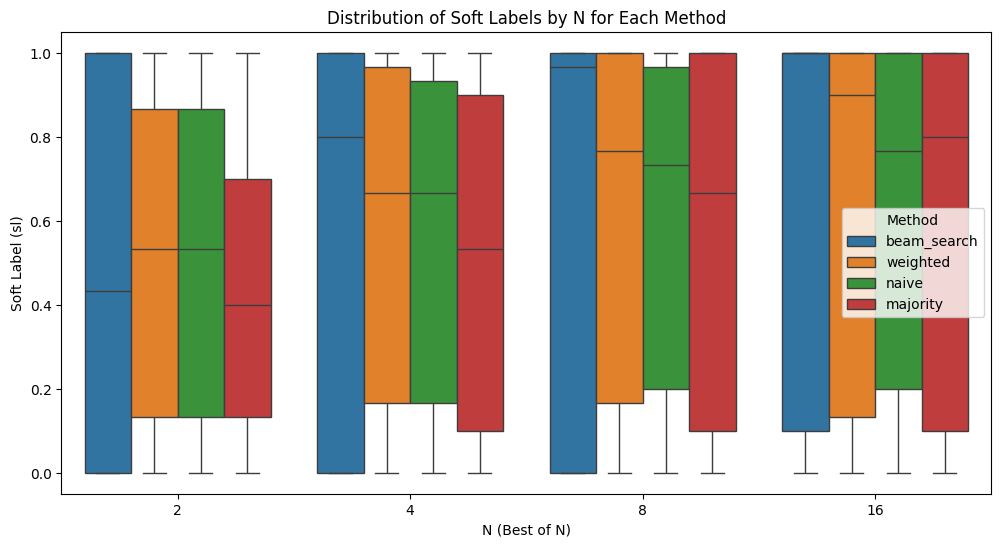

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x="N", y="sl", hue="method", data=predictor_no_hards)
plt.title("Distribution of Soft Labels by N for Each Method")
plt.xlabel("N (Best of N)")
plt.ylabel("Soft Label (sl)")
plt.legend(title="Method")
plt.show()

Observe N=2,4,8,16 for now... we will come back to N=32 when we have collected 5000 questions from beam=32.

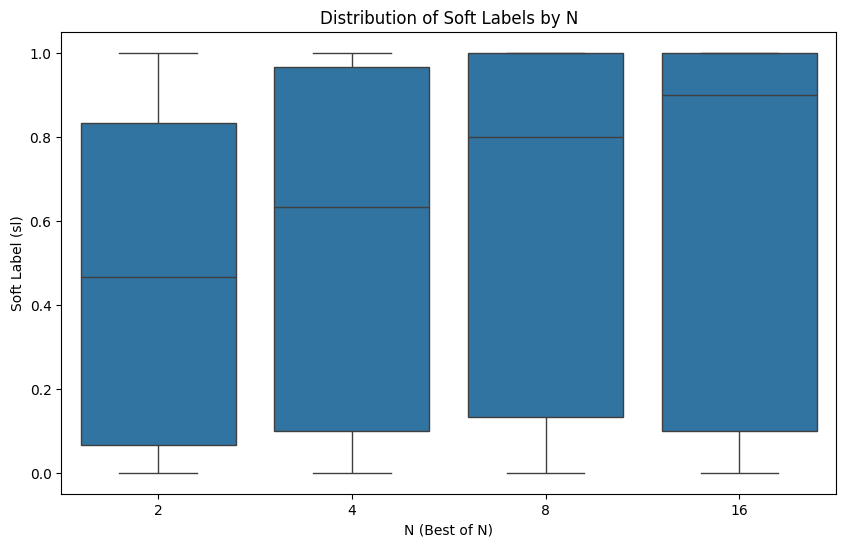

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="N", y="sl", data=predictor_no_hards)
plt.title("Distribution of Soft Labels by N")
plt.xlabel("N (Best of N)")
plt.ylabel("Soft Label (sl)")
plt.show()

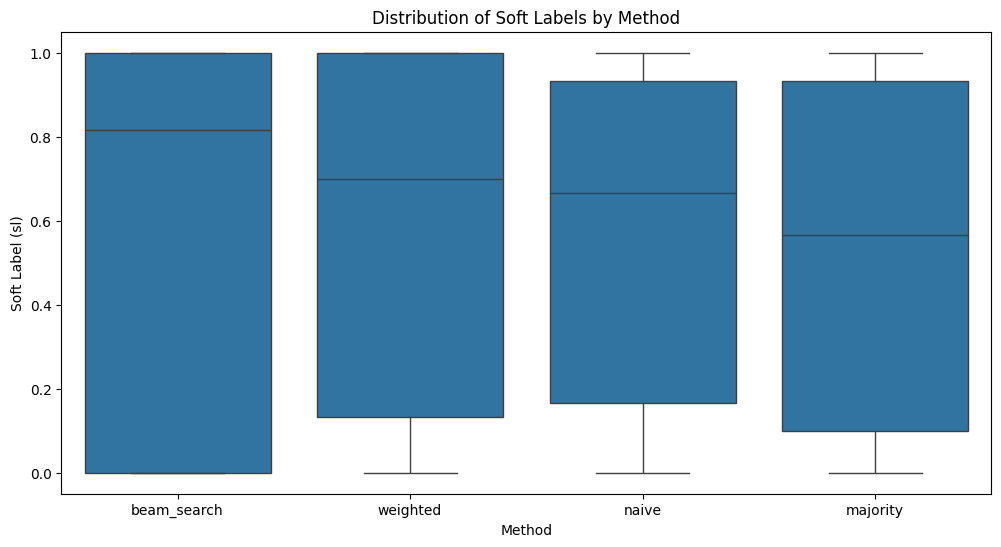

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="method", y="sl", data=predictor_no_hards)
plt.title("Distribution of Soft Labels by Method")
plt.xlabel("Method")
plt.ylabel("Soft Label (sl)")
plt.show()

In [13]:
# use the version without hard problems (for now)
predictor_df = predictor_no_hards

#### Add method columns 1-hot (for training) and combined (for routing).

In [16]:
predictor_df = pd.get_dummies(predictor_df, columns=["method"])

In [17]:
# Transform method columns into a single 'method' column.
def decode_method(row):
    if row["method_majority"]:
        return "majority"
    elif row["method_naive"]:
        return "naive"
    elif row["method_weighted"]:
        return "weighted"
    elif row["method_beam_search"]:
        return "beam_search"
    else:
        return "unknown"

# Apply the function row-wise
predictor_df["method"] = predictor_df.apply(decode_method, axis=1)

In [ ]:
# create train/val/test split based on 'sb_idx' (query identifier)
from sklearn.model_selection import train_test_split

unique_sb_idx = predictor_df['sb_idx'].unique()

# First split into train+val and test
sb_idx_trainval, sb_idx_test = train_test_split(
    unique_sb_idx,
    test_size=0.1,
    random_state=9
)

# Then split train+val into train and val
sb_idx_train, sb_idx_val = train_test_split(
    sb_idx_trainval,
    test_size=0.15,  # 10% of trainval, i.e., 9% of total
    random_state=9
)

# Divide queries (represented by sb_idx) into train, val, and test
df_train = predictor_df[predictor_df['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
df_val = predictor_df[predictor_df['sb_idx'].isin(sb_idx_val)].reset_index(drop=True)
df_test = predictor_df[predictor_df['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

In [15]:
df_train.shape, df_val.shape, df_test.shape

((37440, 10), (6624, 10), (4896, 10))

In [14]:
# df_train.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_train.csv", index=False)
# df_val.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_val.csv", index=False)
# df_test.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_test.csv", index=False)

# read in df_train, df_val, df_test.
df_train = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_train_29000.csv")
# df_val = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_val.csv")
df_test = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_test_29000.csv")
df_train.shape, df_test.shape

/tmp/ipykernel_2962571/4078276759.py:6: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/df_train_29000.csv")


((362573, 10), (64059, 10))

#### EDA: training and testing dataframes by method, N.

/tmp/ipykernel_1922548/1732479970.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1922548/1732479970.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


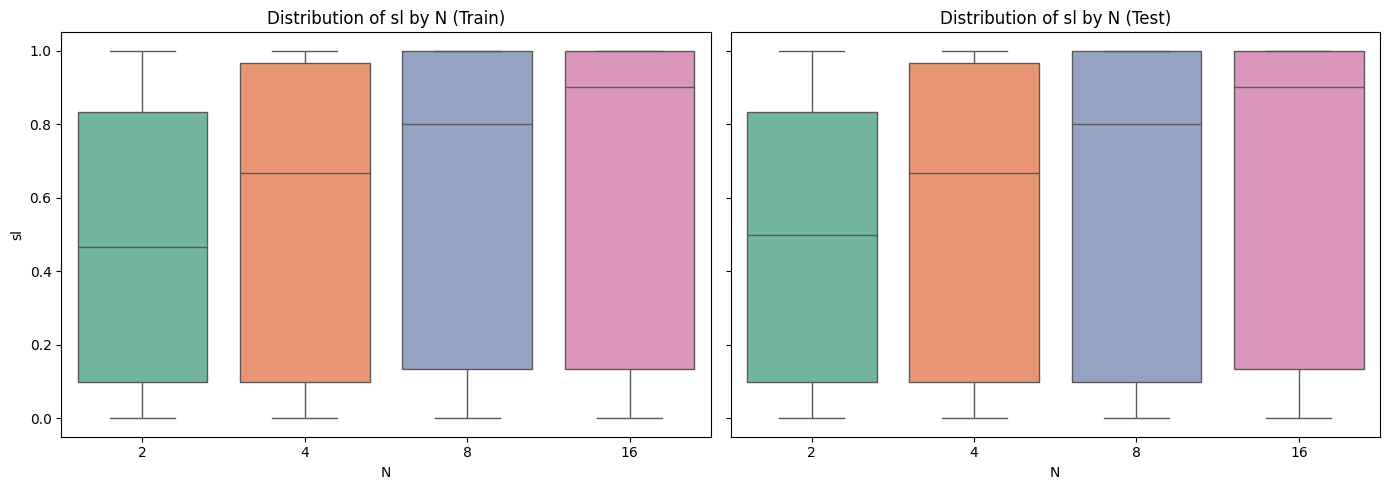

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, (df, name) in enumerate(zip([df_train, df_val], ["Train", "Test"])):
    sns.boxplot(
        x="N", y="sl", data=df, ax=axes[i], showfliers=False, palette="Set2"
    )
    axes[i].set_title(f"Distribution of sl by N ({name})")
    axes[i].set_xlabel("N")
    axes[i].set_ylabel("sl" if i == 0 else "")

plt.tight_layout()
plt.show()


/tmp/ipykernel_1922548/3437444541.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1922548/3437444541.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


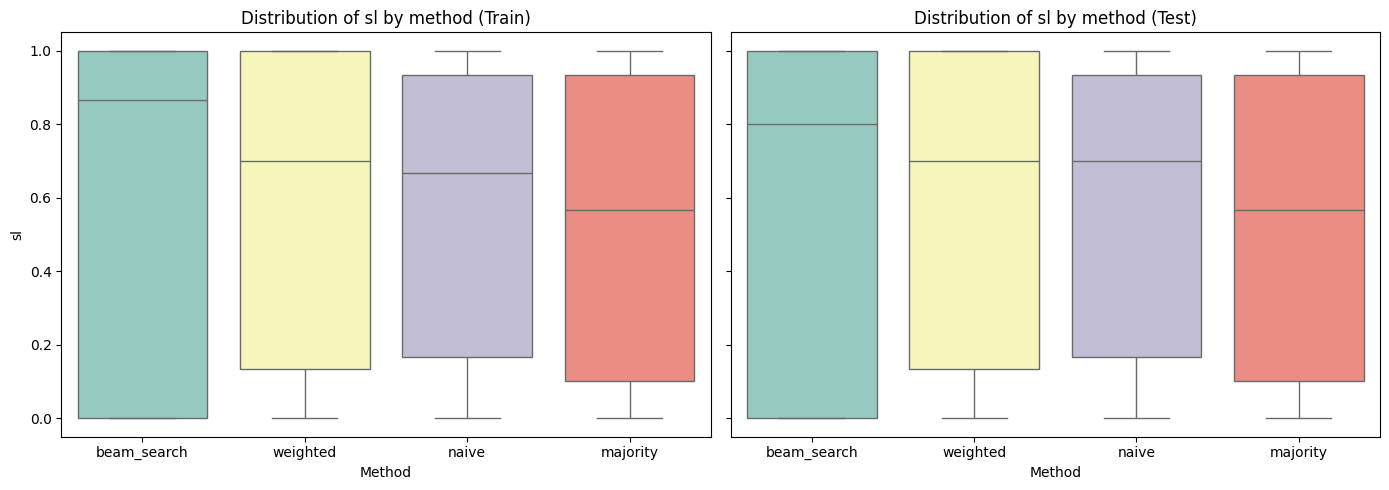

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, (df, name) in enumerate(zip([df_train, df_val], ["Train", "Test"])):
    sns.boxplot(
        x="method", y="sl", data=df, ax=axes[i], showfliers=False, palette="Set3"
    )
    axes[i].set_title(f"Distribution of sl by method ({name})")
    axes[i].set_xlabel("Method")
    axes[i].set_ylabel("sl" if i == 0 else "")

plt.tight_layout()
plt.show()


### Extract Features for Difficulty Probe.

the features are created using Python scripts in the folder labeled "features."

In [16]:
X_train = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/29000/train_features_BERT_pca_32.npy")
y_train = df_train["sl"].values.astype(float)

In [193]:
X_val = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/bert-features/val_features_qwen_max.npy")
y_val = df_val["sl"].values.astype(float)

In [194]:
X_val.shape

(6624, 1542)

### Load in Training/Testing Data

### Train MLP.

In [195]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [196]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [197]:
# Extract only the last 6 features for training and testing
# X_train = X_train[:, -6:]
# X_test = X_test[:, -6:]
# Exclude the first 768 features (BERT embedding) from training/val
# Take BERT embeddings (first 768) and one iteration of auxiliary features (next 6)
# X_train_short = X_train[:, -6:]
# X_test_short = X_test[:, -6:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((37440, 1542), (37440,), (6624, 1542), (6624,))

### Create Custom MLP

In [198]:
import torch
import torch.nn as nn                       
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [202]:
# ----- 2. Dataset Definition -----
class SoftLabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ----- 3. Dataloaders -----
train_dataset = SoftLabelDataset(X_train, y_train)
val_dataset = SoftLabelDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ----- 4. MLP Model - following from the LLM Routing Paper. -----
# Add one repetition of the auxiliary features (last 6 dims) as extra input into each layer

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim,200),
            nn.BatchNorm1d(200),
            nn.GELU(),
            nn.Linear(200, 200),
            nn.BatchNorm1d(200),
            nn.GELU(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=1542)

# ----- 5. Loss and Optimizer -----
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
# Version with repeated numerical features in each layer.
# class MLP(nn.Module):
#     def __init__(self, input_dim):
#         super(MLP, self).__init__()
#         self.input_dim = input_dim
#         # Each layer will receive the original 6 auxiliary features concatenated
#         self.fc1 = nn.Linear(input_dim, 4)
#         self.bn1 = nn.BatchNorm1d(4)
#         self.fc2 = nn.Linear(4 + input_dim, 4)
#         self.bn2 = nn.BatchNorm1d(4)
#         self.fc3 = nn.Linear(4 + input_dim, 1)
#         self.sigmoid = nn.Sigmoid()
#         self.act = nn.GELU()

#     def forward(self, x):
#         aux = x  # Save the auxiliary features
#         out = self.fc1(x)
#         out = self.bn1(out)
#         out = self.act(out)
#         out = torch.cat([out, aux], dim=1)
#         out = self.fc2(out)
#         out = self.bn2(out)
#         out = self.act(out)
#         out = torch.cat([out, aux], dim=1)
#         out = self.fc3(out)
#         out = self.sigmoid(out)
#         return out

# model = MLP(input_dim=6)

# # ----- 5. Loss and Optimizer -----
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [203]:
# ----- 6. Training Loop -----
num_epochs = 250  # Maximum of 10,000 epochs
batch_size = 128    # Batch size of 128
patience = 10      # Early stopping patience

agg_train_loss = []
agg_val_loss = []
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = []
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Validation
    model.eval()
    val_loss = []
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_preds = model(val_X)
            val_loss.append(criterion(val_preds, val_y).item())
    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)

    agg_train_loss.append(mean_train_loss)
    agg_val_loss.append(mean_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {mean_train_loss:.4f}, Val Loss: {mean_val_loss:.4f}")

    # Early stopping
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1, Train Loss: 0.6302, Val Loss: 0.6377
Epoch 2, Train Loss: 0.5451, Val Loss: 0.6233
Epoch 3, Train Loss: 0.4896, Val Loss: 0.6199
Epoch 4, Train Loss: 0.4476, Val Loss: 0.6278
Epoch 5, Train Loss: 0.4185, Val Loss: 0.6393
Epoch 6, Train Loss: 0.4005, Val Loss: 0.6472
Epoch 7, Train Loss: 0.3896, Val Loss: 0.6562
Epoch 8, Train Loss: 0.3827, Val Loss: 0.6649
Epoch 9, Train Loss: 0.3789, Val Loss: 0.6707
Epoch 10, Train Loss: 0.3765, Val Loss: 0.6775
Epoch 11, Train Loss: 0.3742, Val Loss: 0.6801
Epoch 12, Train Loss: 0.3730, Val Loss: 0.6820
Epoch 13, Train Loss: 0.3711, Val Loss: 0.6828
Early stopping at epoch 13


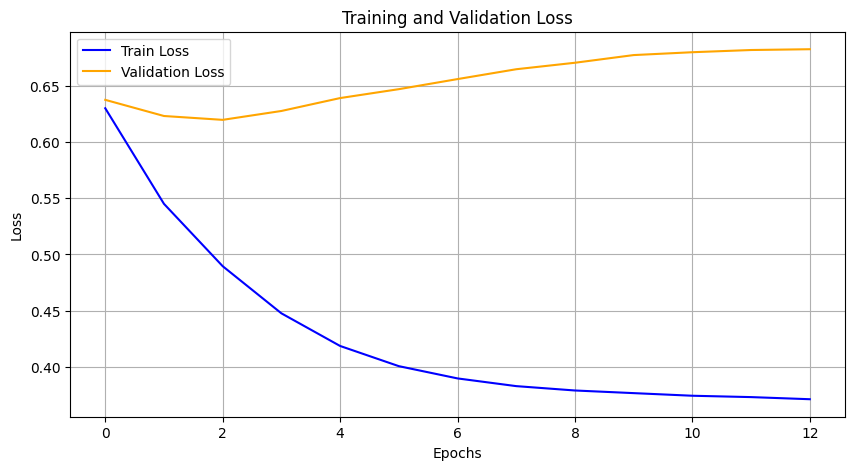

In [204]:
# ----- 7. Plot Training and Validation Loss -----
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(agg_train_loss, label='Train Loss', color='blue')
plt.plot(agg_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Make Predictions on Test.

In [169]:
X_val.shape

(6624, 38)

In [ ]:
model.eval()
X_test_tensor = torch.tensor(X_val, dtype=torch.float32)

with torch.no_grad():
    softLabel_Preds = model(X_test_tensor)

softLabel_preds_numpy = softLabel_Preds.squeeze().cpu().numpy()
softLabel_preds_numpy

plt.figure(figsize=(6, 6))
plt.scatter(softLabel_preds_numpy, y_val, alpha=1e-2)
plt.xlabel("True label (soft)")
plt.ylabel("Predicted probability")
plt.title("Predicted vs True (Soft Label)")
plt.grid(True)
plt.show()

array([0.69832116, 0.71991587, 0.75416046, ..., 0.5498654 , 0.53478146,
       0.74285805], dtype=float32)

In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(softLabel_preds_numpy, y_val, alpha=1e-2)
plt.xlabel("True label (soft)")
plt.ylabel("Predicted probability")
plt.title("Predicted vs True (Soft Label)")
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

### Train XGBoost Classifier

In [143]:
y_train_binary = y_train > 0.5
y_test_binary = y_test > 0.5

In [144]:
import xgboost as xgb

XGBoostmodel = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
XGBoostmodel.fit(X_train, y_train_binary)

/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:57:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [145]:
from sklearn.metrics import roc_auc_score
# compute AUC
# Get predicted probabilities for the positive class (label 1)
y_proba = XGBoostmodel.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test_binary, y_proba)
print(f"AUC: {auc:.4f}")

AUC: 0.6602


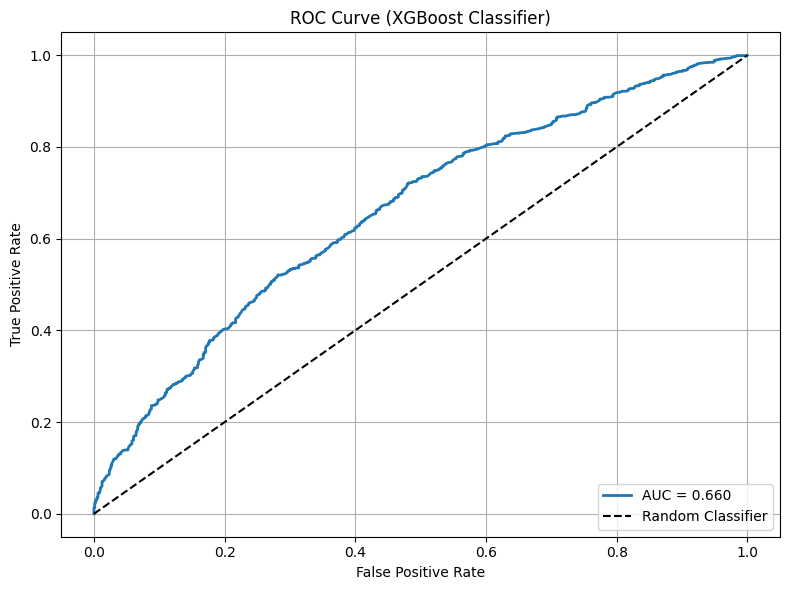

In [147]:
# AUC with all features.

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost Classifier)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

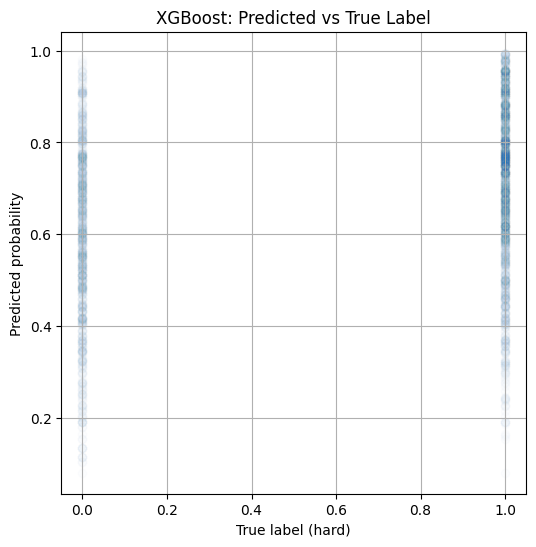

In [148]:
import matplotlib.pyplot as plt
# the XGBoost model does slightly better in outputting predicted probabilities.
plt.figure(figsize=(6, 6))
plt.scatter(y_test_binary, y_proba, alpha=1e-2)
plt.xlabel("True label (hard)")
plt.ylabel("Predicted probability")
plt.title("XGBoost: Predicted vs True Label")
plt.grid(True)
plt.show()

In [ ]:
import shap

explainer = shap.Explainer(model, X_train)     # TreeExplainer under the hood
shap_values = explainer(X_test)               # SHAP values for each sample

/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
question_embedding_shap = shap_values.values[:, :-7]
num_samples_shap = shap_values.values[:, -6]
question_length_shap = shap_values.values[:, -5]
method_maj_shap = shap_values.values[:, -4]
method_naive_shap = shap_values.values[:, -3]
method_weighted_shap = shap_values.values[:, -2]
method_beam_search_shap = shap_values.values[:, -1]  # Beam search method

# Summary statistics
print(f"Mean SHAP value for 'question embedding': {question_embedding_shap.mean():.4f}")
print(f"Mean SHAP value for 'num samples': {num_samples_shap.mean():.4f}")
print(f"Mean SHAP value for 'question length': {question_length_shap.mean():.4f}")
print(f"Mean SHAP value for 'method_maj': {method_maj_shap.mean():.4f}")
print(f"Mean SHAP value for 'method_naive': {method_naive_shap.mean():.4f}")
print(f"Mean SHAP value for 'method_weighted': {method_weighted_shap.mean():.4f}")
print(f"Mean SHAP value for 'method_beam_search': {method_beam_search_shap.mean():.4f}")

Mean SHAP value for 'question embedding': -0.0004
Mean SHAP value for 'num samples': 0.0034
Mean SHAP value for 'question length': -0.0140
Mean SHAP value for 'method_maj': -0.0279
Mean SHAP value for 'method_naive': 0.0297
Mean SHAP value for 'method_weighted': -0.0240
Mean SHAP value for 'method_beam_search': 0.0122


In [89]:
# predict probability of positive class (correct answer) for test set.
# XGBoost Classifier.
# y_proba = model.predict_proba(X_test)[:, 1]
df_test['predicted_prob'] = softLabel_preds_numpy

In [ ]:
# df_train['predicted_prob'] = hardLabel_preds_numpy
# df_test['predicted_prob'] = hardLabel_preds_numpy # PyTorch MLP predictions from hard label.
# df_train['predicted_prob'] = y_proba_train # sklearn MLPClassifier predictions (hard label version)

In [90]:
# there should be 23 different BoN configurations for each query in the test set.
df_test.groupby('sb_idx').size().reset_index(name='count')

,sb_idx,count
0,2,20
1,10,20
2,12,20
3,13,20
4,16,20
...,...,...
95,478,20
96,480,20
97,486,20
98,495,20


In [91]:
df_test.head()

,question,score,completion_tokens,sb_idx,sl,N,question_length,token_count,time,method_beam_search,method_majority,method_naive,method_weighted,method,predicted_prob
0,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,0.92,2,113,688,2.20,False,False,False,True,weighted,0.618690
1,What is the least positive integer multiple of...,"[0.86328125, 0.0708007812, 0.5546875, 0.878906...","[512, 316, 1032, 412, 609, 423, 354, 431, 595,...",10,0.14,2,99,828,3.23,False,False,False,True,weighted,0.132729
2,"The proper divisors of 12 are 1, 2, 3, 4 and 6...","[0.640625, 1.0, 0.99609375, 1.0, 0.1137695312,...","[176, 365, 285, 839, 427, 359, 355, 411, 300, ...",12,0.08,2,215,541,2.12,False,False,False,True,weighted,0.192758
3,The volume of the cylinder shown is $45\pi$ cu...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[277, 248, 237, 251, 221, 198, 152, 248, 282, ...",13,1.00,2,384,525,1.08,False,False,False,True,weighted,0.567352
4,Compute: $1-2+3-4+5- \dots +99-100$.,"[1.0, 1.0, 1.0, 1.0, 0.99609375, 1.0, 1.0, 0.9...","[152, 262, 236, 215, 178, 264, 226, 202, 239, ...",16,0.84,2,36,414,1.60,False,False,False,True,weighted,0.623238


In [172]:
df_test_beam = df_test[df_test["method"] == "beam_search"]

In [130]:
# get the average accuracy and token_count for each configuration of step-beam that was run.
config_summary_df = df_test.groupby(["N", "method"])[
    ["sl", "predicted_prob", "token_count", "time"] # accuracy keeps track of Pass@N (aka, percentage of correct answers).
].mean().reset_index()

In [131]:
config_summary_df.head(20)

,N,method,sl,predicted_prob,token_count,time
0,2,beam_search,0.4048,0.549286,1295.12,5.8316
1,2,majority,0.4220,0.534820,972.13,2.9484
2,2,naive,0.5278,0.540454,972.13,3.0595
3,2,weighted,0.5278,0.542810,972.13,3.0595
4,4,beam_search,0.6381,0.560398,2648.84,7.5129
5,4,majority,0.5138,0.545988,1988.49,3.0719
6,4,naive,0.6062,0.551600,1988.49,3.2847
7,4,weighted,0.6052,0.553942,1988.49,3.2847
8,8,beam_search,0.7298,0.582479,7009.91,15.6604
9,8,majority,0.6000,0.568214,4007.45,3.8376


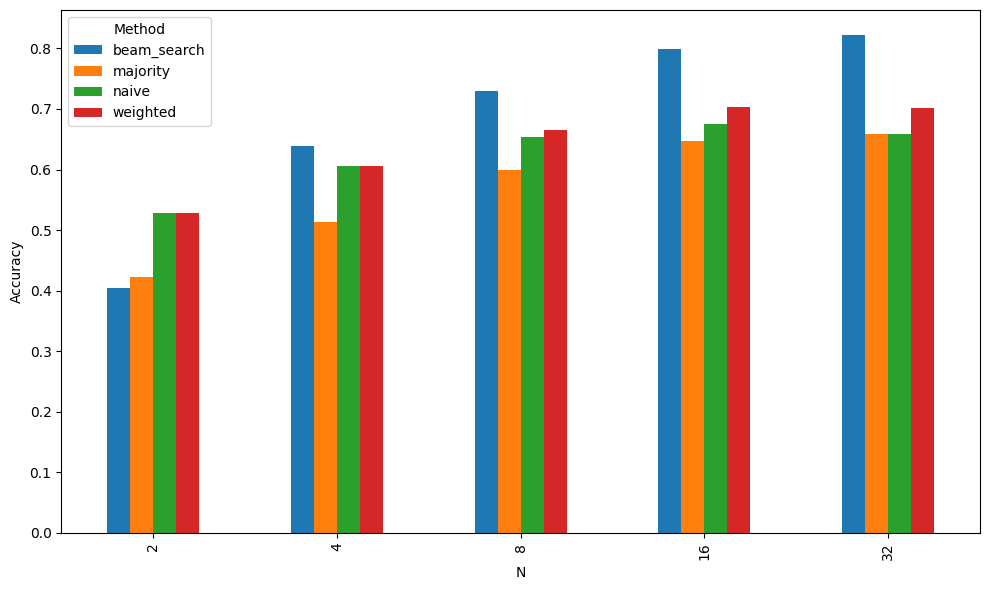

In [134]:
pivot_df = config_summary_df.pivot(index="N", columns="method", values="sl")

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))

# plt.title("Accuracy by N")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

### Optimal-Utility Router

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

$$\text{Query-adaptive}(x, m) = \argmax_m \; \text{Utility}(x, m)

Input: A dataframe that contains rows for different settings (beam size, beam width, chunk size, etc.) and includes: an accuracy column, an avg_cot_token_count column (which is the cost), and a sb_idx column (which is the query).

A parameter, lambda, that controls how much the user is willing to tradeoff accuracy and cost.

For each group (i.e., all rows of the same query, or sb_idx):

It computes a utility value for each row:

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

It finds the row with the highest utility in that group.

Output:
A new DataFrame where each row corresponds to a query and contains:
the best utility found, the accuracy, and cost for that best-performing configuration.

In [192]:
def compute_max_utility_pred(df, lambda_):
    def get_max_utility(group): # verified correctness.
        group = group.copy()
        group["utility"] = group["predicted_prob"] - lambda_ * group["time"]
        idx_max = group["utility"].idxmax()
        # print("max utility index is: ", idx_max)
        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "predicted_prob"],
            "max_sl": group.loc[idx_max, "sl"], # indicator that keeps track of whether the answer is correct.
            "max_cost": group.loc[idx_max, "token_count"],
            "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"],
            "method": group.loc[idx_max, "method"],
        })

    result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
    return result_df

In [155]:
# filter for only method_beam_search.
df_test_beam = df_test[df_test["method"] == "beam_search"]

Selected questions: [138 446 178 134  93 137 442  95 287 408 447 195 402 235  53 212  32 381
 211 397 435 243 263 377  59]


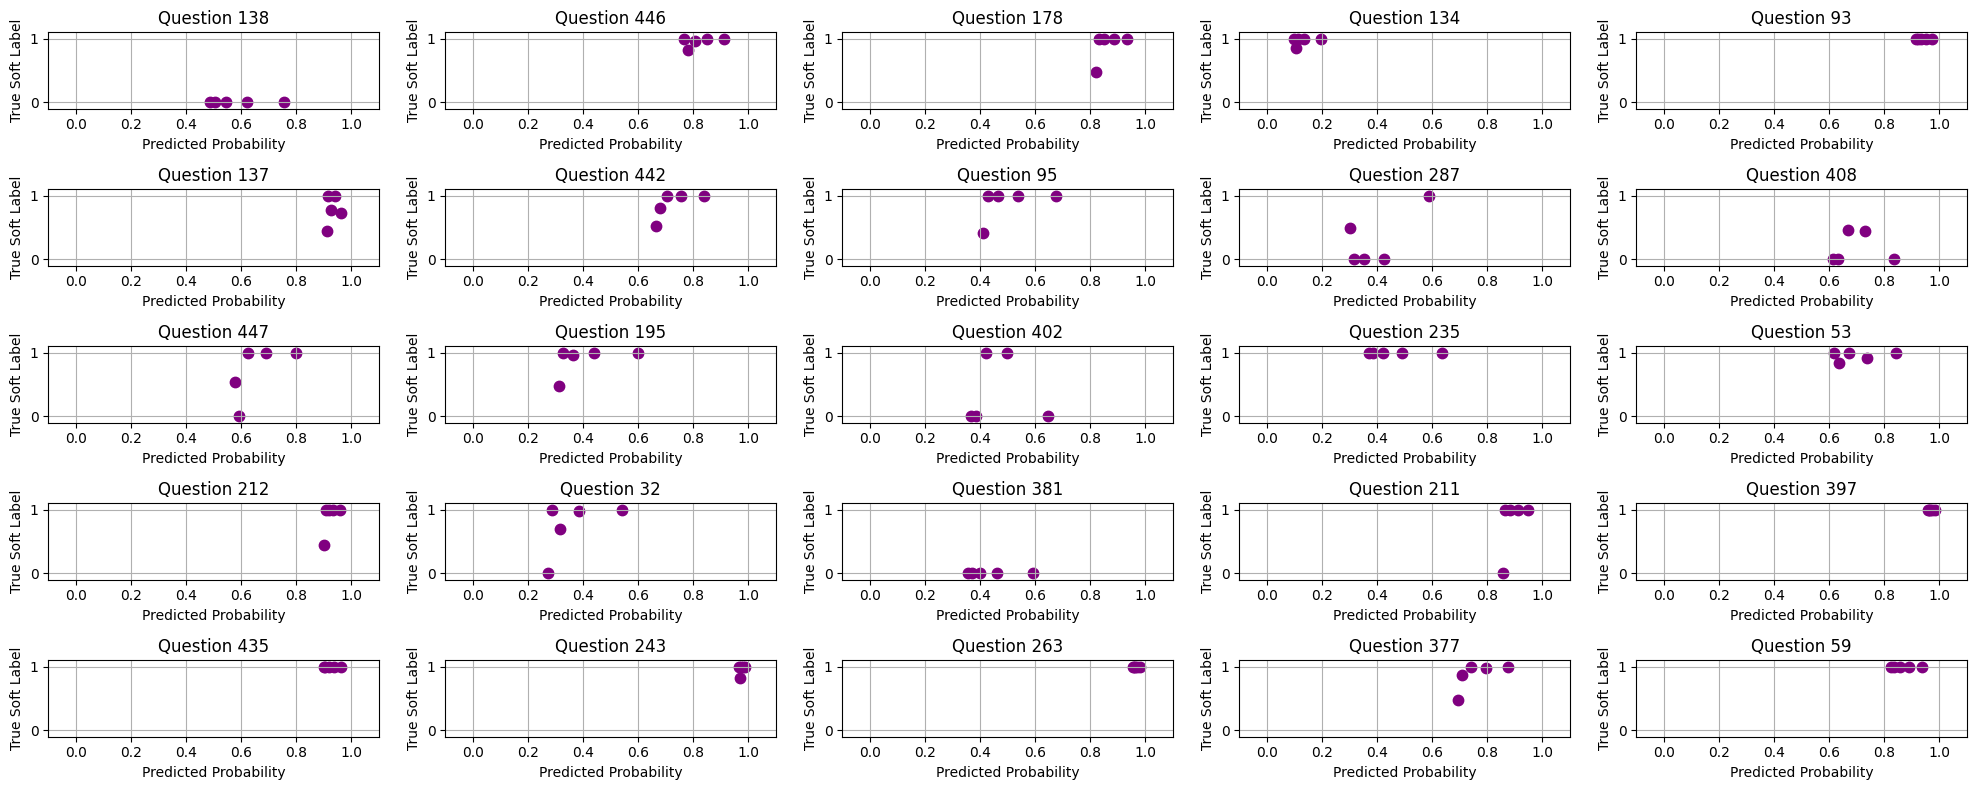

In [156]:
# import matplotlib.pyplot as plt
question = df_test_beam[df_test_beam["sb_idx"] == 10]
# select columns N, indicator, predicted_prob.
question[["N", "sl", "predicted_prob"]]


# Randomly select 10 questions from the test set.
selected_questions = np.random.choice(df_test_beam["sb_idx"].unique(), 25, replace=False)
print(f"Selected questions: {selected_questions}")

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 8))
axes = axes.flatten()  # Flatten to make indexing easier

# Create plots for each selected question
for i, question_idx in enumerate(selected_questions):
    # Get data for this question
    question = df_test_beam[df_test_beam["sb_idx"] == question_idx]
    
    # Create scatter plot
    axes[i].scatter(question["predicted_prob"], question["sl"], 
                    alpha=1, s=56, color="purple")
    axes[i].set_xlim(-0.1, 1.1)
    axes[i].set_ylim(-0.1, 1.1)
    axes[i].set_title(f"Question {question_idx}")
    axes[i].set_xlabel("Predicted Probability")
    axes[i].set_ylabel("True Soft Label")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


Number of questions in test set: 100
Mean proportion correct across all questions: 0.6788
Std proportion correct across all questions: 0.3331


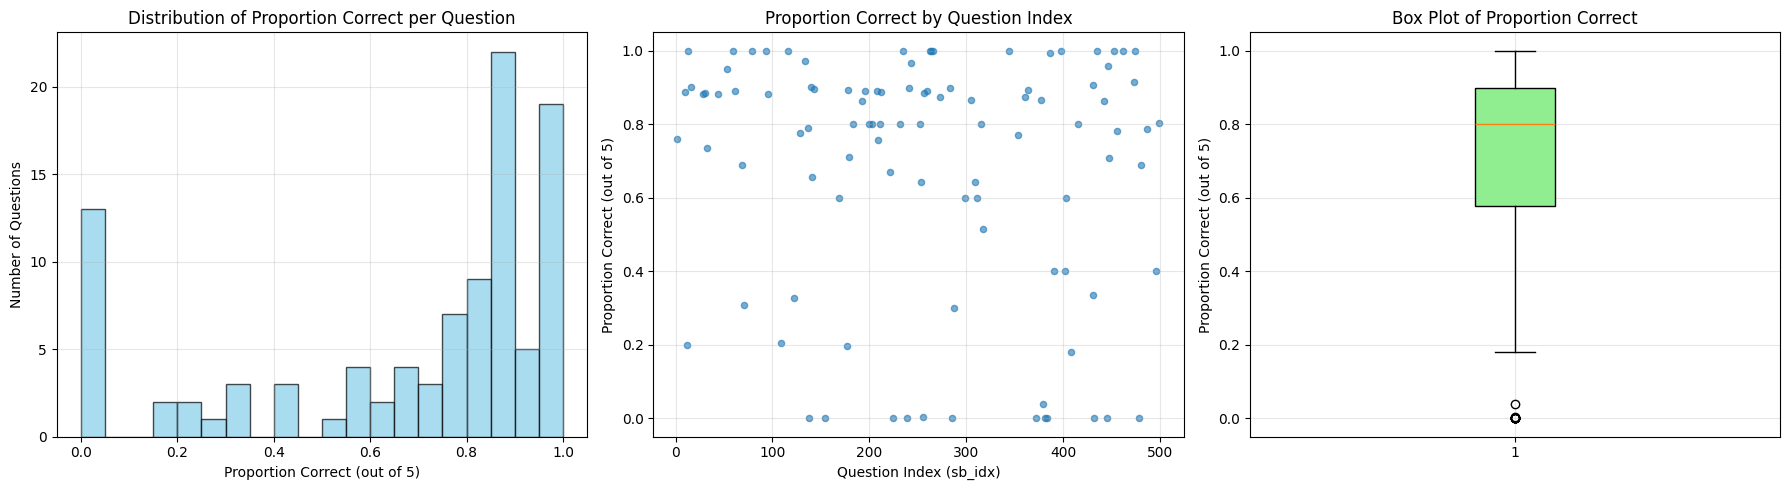


SUMMARY STATISTICS
Minimum proportion correct: 0.0000
25th percentile: 0.5785
Median proportion correct: 0.8000
75th percentile: 0.8980
Maximum proportion correct: 1.0000

BREAKDOWN BY PROPORTION CORRECT RANGES
Proportion 0.0-0.2: 15 questions (15.0%)
Proportion 0.2-0.4: 6 questions (6.0%)
Proportion 0.4-0.6: 4 questions (4.0%)
Proportion 0.6-0.8: 20 questions (20.0%)
Proportion 0.8-1.0: 40 questions (40.0%)

Questions with perfect scores (all 5 correct): 15
Questions with no correct answers: 11


In [157]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate proportion correct for each question in the test set
# Group by sb_idx and calculate the mean of indicator (which gives us the proportion correct)
proportion_correct = df_test_beam.groupby('sb_idx')['sl'].mean()

print(f"Number of questions in test set: {len(proportion_correct)}")
print(f"Mean proportion correct across all questions: {proportion_correct.mean():.4f}")
print(f"Std proportion correct across all questions: {proportion_correct.std():.4f}")

# Create the distribution plot
plt.figure(figsize=(18, 5))

# Create histogram
plt.subplot(1, 3, 1)
plt.hist(proportion_correct, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Proportion Correct (out of 5)')
plt.ylabel('Number of Questions')
plt.title('Distribution of Proportion Correct per Question')
plt.grid(True, alpha=0.3)

# Create scatter plot of proportion correct vs question index
plt.subplot(1, 3, 2)
plt.scatter(proportion_correct.index, proportion_correct.values, alpha=0.6, s=20)
plt.xlabel('Question Index (sb_idx)')
plt.ylabel('Proportion Correct (out of 5)')
plt.title('Proportion Correct by Question Index')
plt.grid(True, alpha=0.3)

# Create box plot
plt.subplot(1, 3, 3)
plt.boxplot(proportion_correct, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.ylabel('Proportion Correct (out of 5)')
plt.title('Box Plot of Proportion Correct')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Minimum proportion correct: {proportion_correct.min():.4f}")
print(f"25th percentile: {proportion_correct.quantile(0.25):.4f}")
print(f"Median proportion correct: {proportion_correct.median():.4f}")
print(f"75th percentile: {proportion_correct.quantile(0.75):.4f}")
print(f"Maximum proportion correct: {proportion_correct.max():.4f}")

# Count questions by proportion correct ranges
print("\n" + "="*60)
print("BREAKDOWN BY PROPORTION CORRECT RANGES")
print("="*60)
ranges = [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
for low, high in ranges:
    count = ((proportion_correct >= low) & (proportion_correct < high)).sum()
    percentage = (count / len(proportion_correct)) * 100
    print(f"Proportion {low:.1f}-{high:.1f}: {count} questions ({percentage:.1f}%)")

# Questions with perfect scores (all 5 correct)
perfect_questions = proportion_correct[proportion_correct == 1.0]
print(f"\nQuestions with perfect scores (all 5 correct): {len(perfect_questions)}")

# Questions with no correct answers
zero_correct_questions = proportion_correct[proportion_correct == 0.0]
print(f"Questions with no correct answers: {len(zero_correct_questions)}")

#### When Lambda = 0.

In [176]:
adaptive_router_this_lambda = compute_max_utility_pred(df_test, 9e-9)
# view rows 10 through 20.
# daptive_router_0_lambda.iloc[0:60]
# view rows 10 through 20.

/tmp/ipykernel_2933550/2682129061.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()


Router is almost always routing between weighted and beam search, transitioning slowly weighted -> beam search as lambda increases.

/tmp/ipykernel_2933550/2134181990.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_2933550/2134181990.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_2933550/2134181990.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

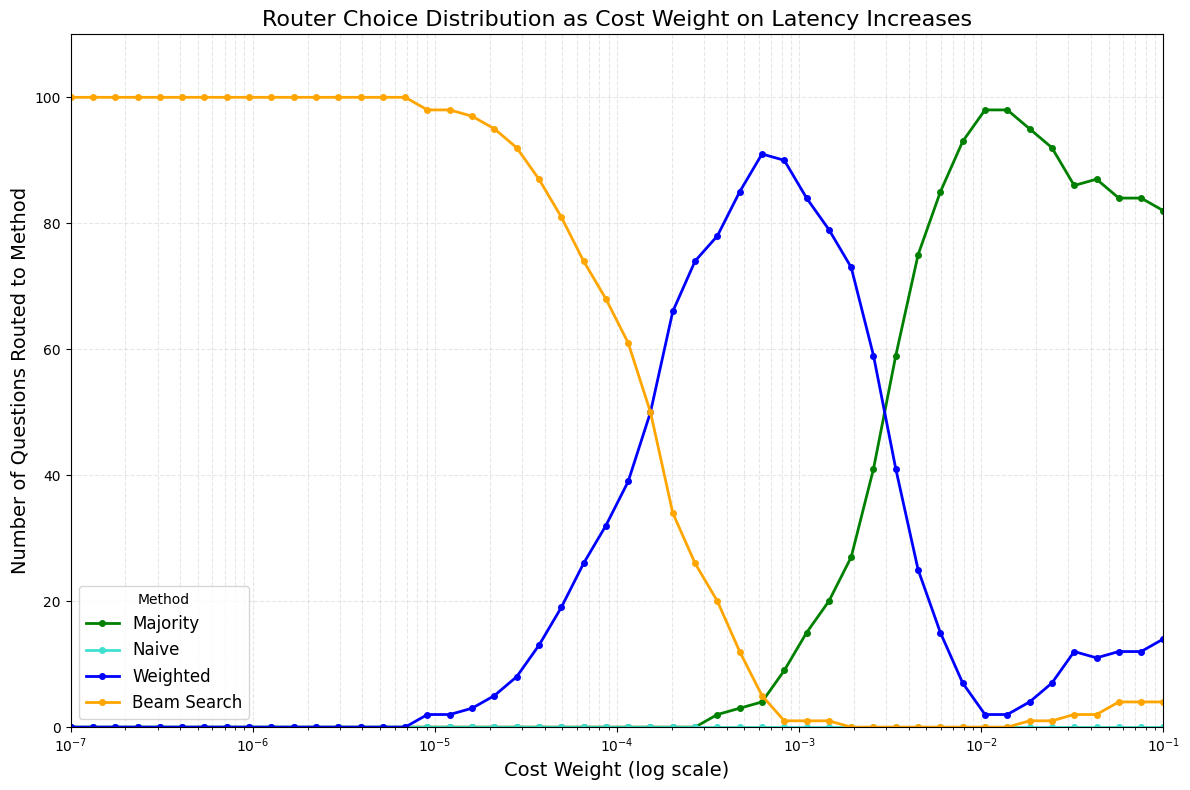

In [196]:
# Plot progression of method distribution as lambda increases from 0 to 1
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create a range of lambda values from 0 to 1
lambda_values = np.logspace(-7, -1, num=50) 

# Store results for each lambda
method_distributions = []

for lambda_val in lambda_values:
    # Compute optimal method selection for this lambda
    adaptive_router = compute_max_utility_pred(df_test, lambda_val)
    
    # Count the frequency of each method
    method_counts = adaptive_router['method'].value_counts()
    
    # Store the distribution
    method_distributions.append({
        'lambda': lambda_val,
        'majority': method_counts.get('majority', 0),
        'naive': method_counts.get('naive', 0),
        'weighted': method_counts.get('weighted', 0),
        'beam_search': method_counts.get('beam_search', 0)
    })

# Convert to DataFrame
dist_df = pd.DataFrame(method_distributions)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each method as a line
methods = ['majority', 'naive', 'weighted', 'beam_search']
colors = ['green', 'turquoise', 'blue', 'orange']

for method, color in zip(methods, colors):
    plt.plot(dist_df['lambda'], dist_df[method], 
             label=method.replace('_', ' ').title(), 
             color=color, linewidth=2, marker='o', markersize=4)

plt.xscale('log')  # Set x-axis to log scale

# Optionally adjust axis limits to fit data better
plt.xlim(dist_df['lambda'].min(), dist_df['lambda'].max())
plt.ylim(0, dist_df[methods].values.max() * 1.1)

plt.xlabel('Cost Weight (log scale)', fontsize=14)
plt.ylabel('Number of Questions Routed to Method', fontsize=14)
plt.title('Router Choice Distribution as Cost Weight on Latency Increases', fontsize=16)
plt.legend(title='Method', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# this_lambda = 9e-5
# adaptive_router_this_lambda = compute_max_utility_pred(df_test, this_lambda)

# # Plot: Histogram of N values
# plt.figure(figsize=(8, 4))
# sns.countplot(data=adaptive_router_this_lambda, x="method", order=sorted(adaptive_router_this_lambda["method"].unique()), color="black")
# plt.title("Frequency of Chosen N Value")
# plt.xlabel("N")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.show()

/tmp/ipykernel_2933550/2134181990.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_2933550/2134181990.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_2933550/2134181990.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

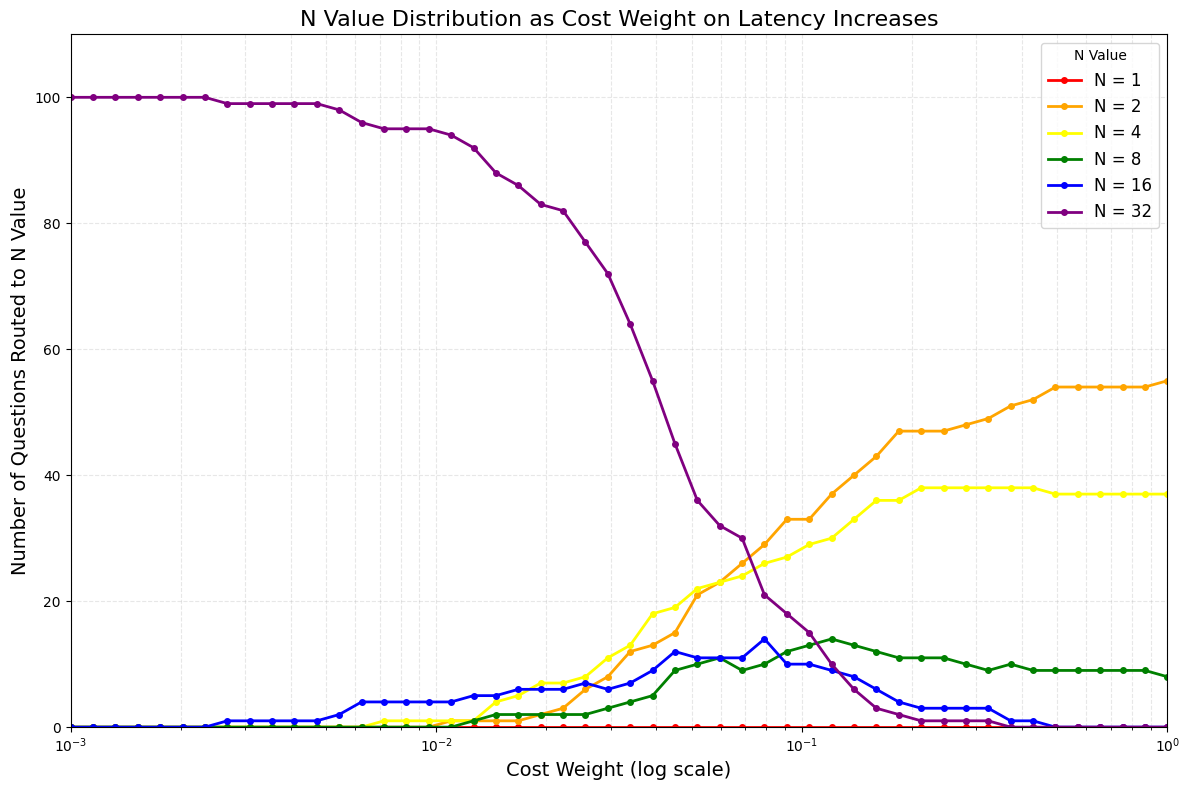

In [198]:
# Create a range of lambda values from 0 to 1 (log scale for better visualization)
lambda_values = np.logspace(-3, -0, num=50) 

# Store results for each lambda
n_distributions = []

for lambda_val in lambda_values:
    # Compute optimal method selection for this lambda
    adaptive_router = compute_max_utility_pred(df_test, lambda_val)
    
    # Count the frequency of each N value
    n_counts = adaptive_router['N'].value_counts()
    
    # Store the distribution
    n_distributions.append({
        'lambda': lambda_val,
        'N_1': n_counts.get(1.0, 0),
        'N_2': n_counts.get(2.0, 0),
        'N_4': n_counts.get(4.0, 0),
        'N_8': n_counts.get(8.0, 0),
        'N_16': n_counts.get(16.0, 0),
        'N_32': n_counts.get(32.0, 0)
    })

# Convert to DataFrame
dist_df = pd.DataFrame(n_distributions)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each N value as a line
n_values = ['N_1', 'N_2', 'N_4', 'N_8', 'N_16', 'N_32']
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

for n_val, color in zip(n_values, colors):
    plt.plot(dist_df['lambda'], dist_df[n_val], 
                label=n_val.replace('_', ' = '), 
                color=color, linewidth=2, marker='o', markersize=4)

plt.xscale('log')  # Set x-axis to log scale

# Optionally adjust axis limits to fit data better
plt.xlim(dist_df['lambda'].min(), dist_df['lambda'].max())
plt.ylim(0, dist_df[n_values].values.max() * 1.1)

plt.xlabel('Cost Weight (log scale)', fontsize=14)
plt.ylabel('Number of Questions Routed to N Value', fontsize=14)
plt.title('N Value Distribution as Cost Weight on Latency Increases', fontsize=16)
plt.legend(title='N Value', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

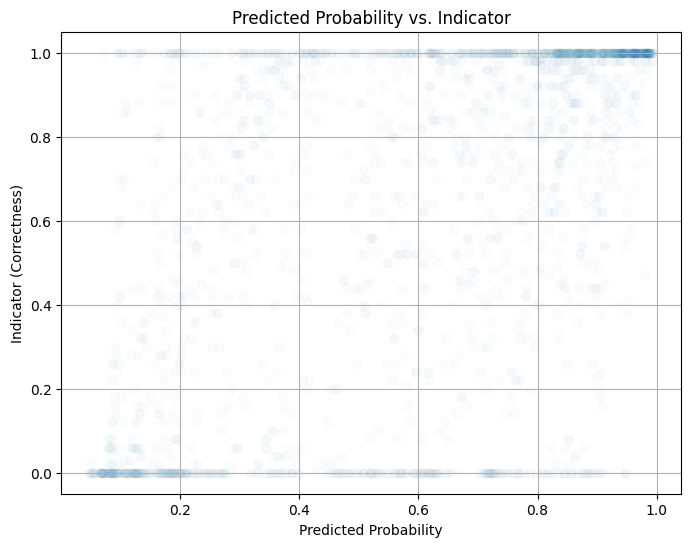

In [97]:
df_test.head()
# create a scatter plot of predicted probability vs. indicator.
plt.figure(figsize=(8, 6))
plt.scatter(df_test["predicted_prob"], df_test["sl"], alpha=0.02)
plt.xlabel("Predicted Probability")
plt.ylabel("Indicator (Correctness)")
plt.title("Predicted Probability vs. Indicator")
plt.grid(True)
plt.show()

/tmp/ipykernel_2933550/2215464222.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_test.groupby("bin").agg(


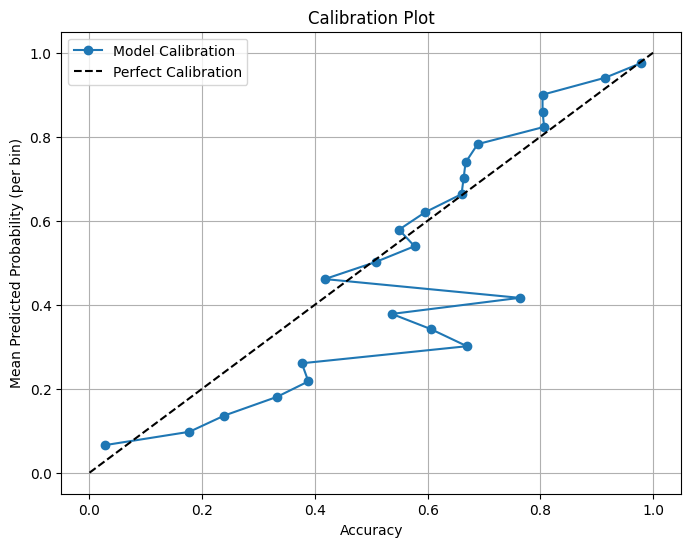

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define bin edges and assign each predicted_prob to a bin
num_bins = 25
df_test["bin"] = pd.cut(df_test["predicted_prob"], bins=np.linspace(0, 1, num_bins + 1), include_lowest=True)

# Group by bins and compute average predicted prob and accuracy
calibration = df_test.groupby("bin").agg(
    avg_pred_prob=("predicted_prob", "mean"),
    accuracy=("sl", "mean"),
    count=("sl", "count")
).dropna()

# Plot calibration curve with flipped axes
plt.figure(figsize=(8, 6))
plt.plot(calibration["accuracy"], calibration["avg_pred_prob"], marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Accuracy")
plt.ylabel("Mean Predicted Probability (per bin)")
plt.title("Calibration Plot")
plt.grid(True)
plt.legend()
plt.show()


In [102]:
# Sweep over lambda values
lambda_list = np.logspace(-50, -1, num=200) 

In [139]:
results = []

for lambda_value in lambda_list:
    adaptive_router = compute_max_utility_pred(df_test, lambda_value)
    average_accuracy = adaptive_router["max_sl"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
    average_cost = adaptive_router["max_cost"].mean()
    average_time = adaptive_router["max_time"].mean()
    average_predicted_prob = adaptive_router["max_predicted_prob"].mean()
    
    results.append({
        "lambda": lambda_value,
        "sl": average_accuracy,
        "token_count": average_cost,
        "predicted_prob": average_predicted_prob,
        "time": average_time,
    })

# Convert to DataFrame
# query_adaptive_df = pd.DataFrame(results)
oracle_df = pd.DataFrame(results)

/tmp/ipykernel_2933550/3875632027.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_2933550/3875632027.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_2933550/3875632027.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

In [140]:
# query_adaptive_df["method"] = "adaptive"
# query_adaptive_df.head()
oracle_df['method'] = 'oracle'
oracle_df.head()

,lambda,sl,token_count,predicted_prob,time,method
0,1.000000e-50,0.8801,7040.91,0.608217,9.5193,oracle
1,1.762914e-50,0.8801,7040.91,0.608217,9.5193,oracle
2,3.107866e-50,0.8801,7040.91,0.608217,9.5193,oracle
3,5.478901e-50,0.8801,7040.91,0.608217,9.5193,oracle
4,9.658832e-50,0.8801,7040.91,0.608217,9.5193,oracle


In [141]:
# rename column indicator to accuracy.
config_summary_df

,N,method,sl,predicted_prob,token_count,time
0,2,beam_search,0.4048,0.549286,1295.12,5.8316
1,2,majority,0.4220,0.534820,972.13,2.9484
2,2,naive,0.5278,0.540454,972.13,3.0595
3,2,weighted,0.5278,0.542810,972.13,3.0595
4,4,beam_search,0.6381,0.560398,2648.84,7.5129
5,4,majority,0.5138,0.545988,1988.49,3.0719
6,4,naive,0.6062,0.551600,1988.49,3.2847
7,4,weighted,0.6052,0.553942,1988.49,3.2847
8,8,beam_search,0.7298,0.582479,7009.91,15.6604
9,8,majority,0.6000,0.568214,4007.45,3.8376


In [ ]:
### TESTING DF
# Pivot for plotting
pivot_df = config_summary_df_test.pivot(index="N", columns="method", values="sl")

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))

plt.title("MV, BoN, Weighted BoN - Accuracy by N")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

In [142]:
# outer join on the shared columns ("accuracy", "avg_cot_token_count")
query_optimal_static_df = pd.merge(
    query_adaptive_df,
    config_summary_df,
    on=["sl", "token_count", "time", "method", "predicted_prob"],
    how="outer"
)
query_optimal_static_df.head()
# change NaN to -1 for plotting purposes.
query_optimal_static_df = query_optimal_static_df.fillna(-1)

In [143]:
query_optimal_static_df

,lambda,sl,token_count,predicted_prob,time,method,N
0,-1.000000e+00,0.4048,1295.12,0.549286,5.8316,beam_search,2.0
1,-1.000000e+00,0.4220,972.13,0.534820,2.9484,majority,2.0
2,6.294989e-05,0.4715,941.08,0.546605,3.5529,adaptive,-1.0
3,3.570786e-05,0.4789,1008.93,0.549721,3.7249,adaptive,-1.0
4,1.109752e-04,0.4811,935.19,0.546114,3.5337,adaptive,-1.0
...,...,...,...,...,...,...,...
215,2.327202e-09,0.8222,31613.52,0.707818,54.7503,adaptive,-1.0
216,4.102658e-09,0.8222,31613.52,0.707818,54.7503,adaptive,-1.0
217,7.232634e-09,0.8222,31613.52,0.707818,54.7503,adaptive,-1.0
218,1.275051e-08,0.8222,31613.52,0.707818,54.7503,adaptive,-1.0


Join the Oracle.

In [144]:
query_optimal_static_df = pd.merge(
    query_optimal_static_df,
    oracle_df,
    on=["lambda", "sl", "token_count", "predicted_prob", "time", "method"],
    how="outer"
)

In [147]:
# Replace NaN values with -1 for plotting purposes
query_optimal_static_df = query_optimal_static_df.fillna(-1)

# Display the merged DataFrame
query_optimal_static_df

,lambda,sl,token_count,predicted_prob,time,method,N
0,-1.000000,0.4048,1295.12,0.549286,5.8316,beam_search,2.0
1,-1.000000,0.4220,972.13,0.534820,2.9484,majority,2.0
2,-1.000000,0.5138,1988.49,0.545988,3.0719,majority,4.0
3,-1.000000,0.5278,972.13,0.540454,3.0595,naive,2.0
4,-1.000000,0.5278,972.13,0.542810,3.0595,weighted,2.0
...,...,...,...,...,...,...,...
415,0.032176,0.5064,927.96,0.544582,3.4110,oracle,-1.0
416,0.056724,0.5060,927.96,0.544709,3.4133,adaptive,-1.0
417,0.056724,0.5064,927.96,0.544582,3.4110,oracle,-1.0
418,0.100000,0.5060,927.96,0.544709,3.4133,adaptive,-1.0


In [152]:
# arrange in descending order of sl.
query_optimal_static_df.sort_values(by="sl", ascending=True)

,lambda,sl,token_count,predicted_prob,time,method,N
0,-1.000000e+00,0.4048,1295.12,0.549286,5.8316,beam_search,2.0
1,-1.000000e+00,0.4220,972.13,0.534820,2.9484,majority,2.0
392,6.294989e-05,0.4715,941.08,0.546605,3.5529,adaptive,-1.0
390,3.570786e-05,0.4789,1008.93,0.549721,3.7249,adaptive,-1.0
394,1.109752e-04,0.4811,935.19,0.546114,3.5337,adaptive,-1.0
...,...,...,...,...,...,...,...
207,7.934097e-28,0.8801,7040.91,0.608217,9.5193,oracle,-1.0
211,2.465811e-27,0.8801,7040.91,0.608217,9.5193,oracle,-1.0
213,4.347013e-27,0.8801,7040.91,0.608217,9.5193,oracle,-1.0
183,8.804884e-31,0.8801,7040.91,0.608217,9.5193,oracle,-1.0


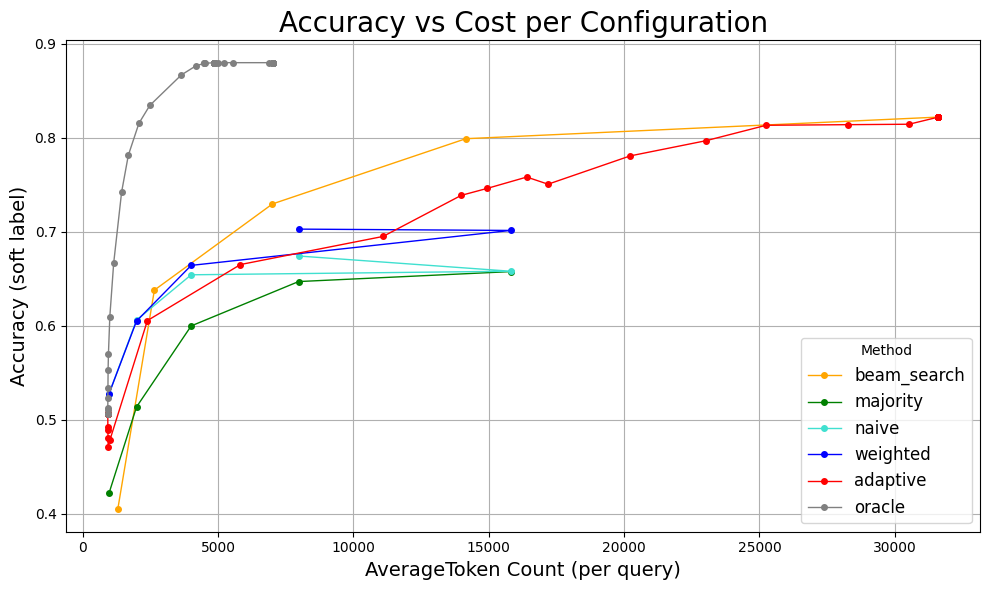

In [149]:
# Assign unique colors for each method
method_colors = {
    "majority": "green",
    "naive": "turquoise",
    "weighted": "blue",
    "beam_search": "orange",
    "adaptive": "red",  # Query-adaptive router
    "oracle": "gray"  # Oracle router
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_static_df["method"].unique():
    method_df = query_optimal_static_df[query_optimal_static_df["method"] == method]
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("AverageToken Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'weightedx8.0', 'majorityx16.0', 'qa', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


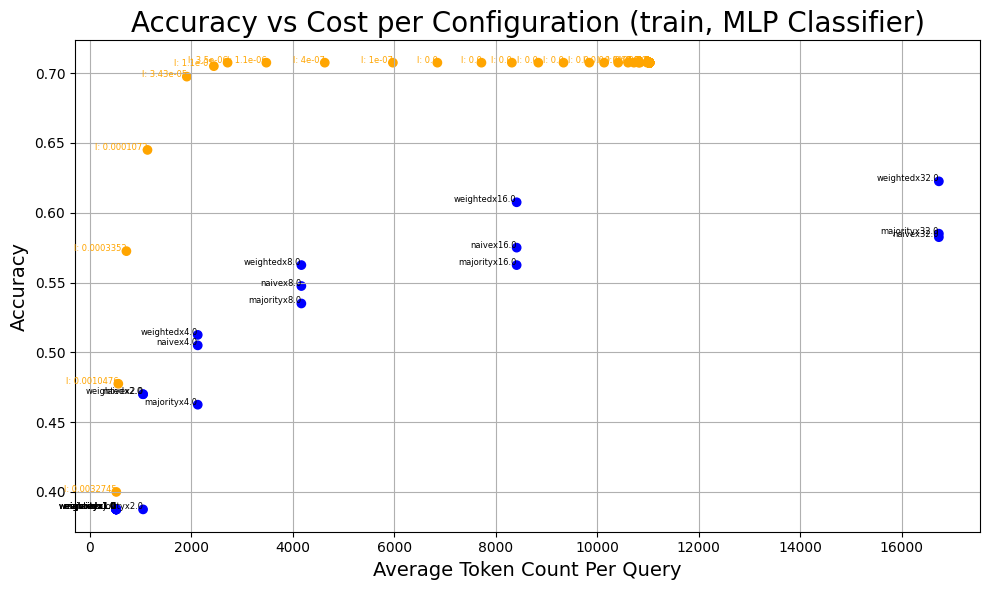

In [ ]:
# Create color labels and text labels (sklearn MLPClassifier)
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration (train, MLP Classifier)", fontsize=20)
plt.grid(True)
plt.tight_layout()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'qa', 'qa', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'qa', 'weightedx8.0', 'majorityx16.0', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


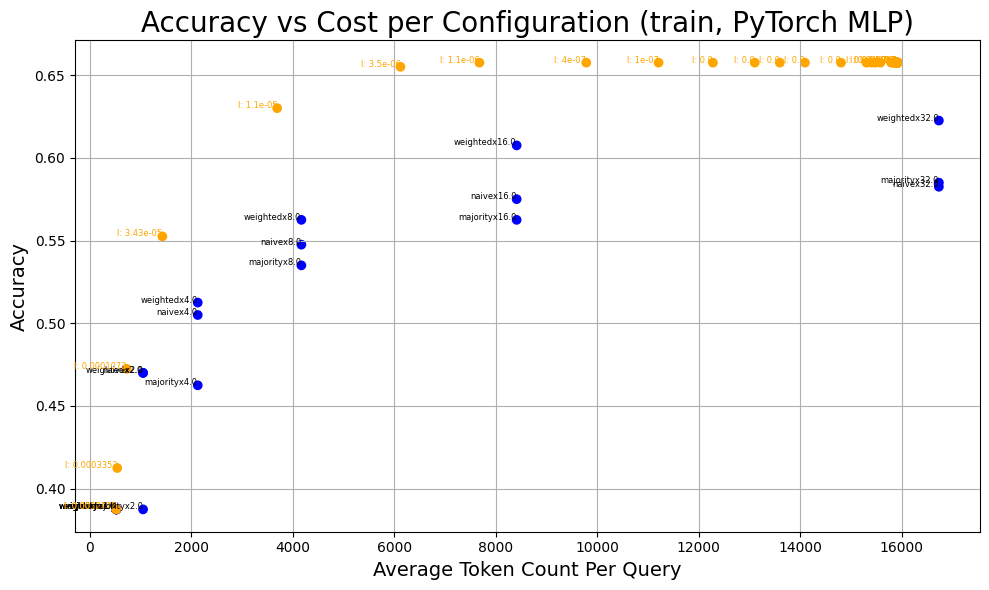

In [ ]:
# Create color labels and text labels (pyTorch MLP)
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration (train, PyTorch MLP)", fontsize=20)
plt.grid(True)
plt.tight_layout()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'weightedx8.0', 'majorityx16.0', 'qa', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


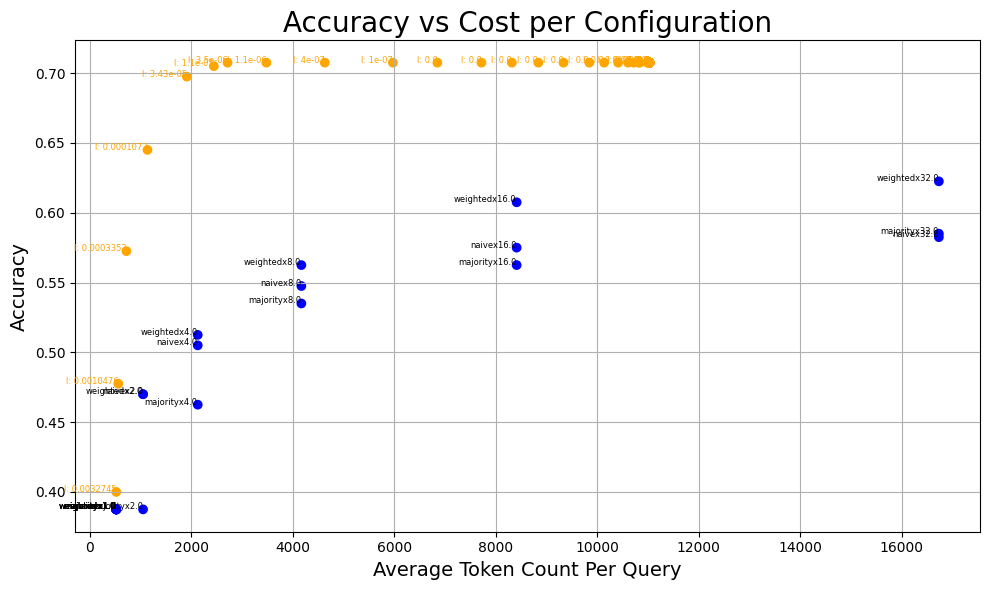

In [ ]:
# Create color labels and text labels
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.grid(True)
plt.tight_layout()

# plt.savefig("figs/accuracy_vs_cost_by_config3", dpi=300, bbox_inches='tight')

# notes: make sure we are plotting the accuracy. the probe should pick the weighted response.
# should not go below the blue dots. (check what you are actually plotting).